In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs


CSV_FILE = '/media/sebo-hri-lab/DATA/OpenFace/group_CD_camera2_trim.csv'
VIDEO_FILE = "/media/sebo-hri-lab/DATA/OpenFace/group_CD_camera2_trim.avi"

GAZE_ANGLE_X = ' gaze_angle_x'
GAZE_ANGLE_Y = ' gaze_angle_y'
GAZE_0_X = ' gaze_0_x'
GAZE_0_Y = ' gaze_0_y'
GAZE_0_Z = ' gaze_0_z'
GAZE_1_X = ' gaze_1_x'
GAZE_1_Y = ' gaze_1_y'
GAZE_1_Z = ' gaze_1_z'

In [2]:
df = pd.read_csv(CSV_FILE)


In [13]:
def edge_projection(row, frame_shape):
    # frame shape is (width, height)

    x_plane_normal = np.array([1, 0, 0])

    if row[GAZE_0_X] > 0:
        # participant is looking right
        x_plane_point = np.array([frame_shape[0], 0, 0])
    else:
        # participant is looking left
        x_plane_point = np.array([0, 0, 0])

    y_plane_normal = np.array([0, 1, 0])
    
    if row[GAZE_0_Y] > 0:
        # participant is looking down
        y_plane_point = np.array([0, frame_shape[1], 0])
    else:
        # participant is looking up
        y_plane_point = np.array([0, 0, 0])

    line_point = np.array([row[' eye_lmk_x_0'], row[' eye_lmk_y_0'], 0])

    line_vector = np.array([row[GAZE_0_X], row[GAZE_0_Y], row[GAZE_0_Z]])

    x_t = np.dot((x_plane_point - line_point), x_plane_normal) / np.dot(line_vector, x_plane_normal)

    y_t = np.dot((y_plane_point - line_point), y_plane_normal) / np.dot(line_vector, y_plane_normal)

    if np.abs(x_t) < np.abs(y_t):
        # gaze falls on the left/right edge
        return (line_point + line_vector * x_t).astype(int)
    else:
        # gaze falls on the upper/lower edge
        return (line_point + line_vector * y_t).astype(int)

In [4]:
vectorList = np.zeros((len(df),6))
for index, row in df.iterrows():
    if(row[GAZE_ANGLE_X] or row[GAZE_ANGLE_Y]):
        vectorList[index] = [row[GAZE_0_X], row[GAZE_0_Y], row[GAZE_0_Z], row[GAZE_1_X], row[GAZE_1_Y], row[GAZE_1_Z]]

In [5]:
kmeans = KMeans(n_clusters=5, random_state=0).fit(vectorList)

predictions = kmeans.predict(vectorList)

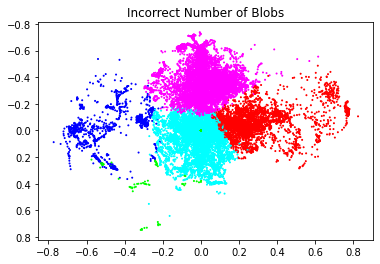

In [6]:
colors = np.array([(0,0,1),(0,1,0),(1,0,1),(0,1,1),(1,0,0),(0,0.4,1)])

plt.scatter(vectorList[:, 3], vectorList[:, 4], c=colors[predictions], s=1)
plt.title("Incorrect Number of Blobs")
plt.gca().invert_yaxis()
plt.savefig('class.png')

In [7]:
from sklearn.decomposition import PCA

kmeansPCA = PCA(3)

kmeansPCA.fit(vectorList)

V = kmeansPCA.components_.T

print(V)

[[-0.14138134 -0.07896714 -0.69849255]
 [ 0.10601643  0.69415953 -0.08242946]
 [ 0.6876625  -0.10724401 -0.09476953]
 [-0.02731905 -0.10728353 -0.69151206]
 [ 0.10974427  0.68728778 -0.12773056]
 [ 0.69505538 -0.12857377 -0.04275809]]


In [21]:
import cv2

cap = cv2.VideoCapture(VIDEO_FILE)
i = 0
colors = [(255,0,0),(0,255,0),(255,0,255),(255,255,0),(0,0,255),(255,100,0)]
frame_width = int(cap.get(3))
frame_height = int(cap.get(4))
BOX_RADIUS = 10
#out = cv2.VideoWriter('classificationExaaze.avi',cv2.VideoWriter_fourcc('M','J','P','G'), 100, (frame_width,frame_height))
while True:
    _, frame = cap.read()
    row = df.iloc[i]
    if(row[GAZE_ANGLE_X] or row[GAZE_ANGLE_Y]):
        vec = [[row[GAZE_0_X], row[GAZE_0_Y],row[GAZE_0_Z], row[GAZE_1_X], row[GAZE_1_Y], row[GAZE_1_Z]]]
    #, row[' gaze_0_x'], row[' gaze_0_y'], row[' gaze_0_z'], row[' gaze_1_x'], row[' gaze_1_y'], row[' gaze_1_z']]]
        clus = kmeans.predict(vec)[0]
        gaze_target = edge_projection(row, (frame_width, frame_height))
        cv2.rectangle(frame,(gaze_target[0]-BOX_RADIUS,gaze_target[1]-BOX_RADIUS),(gaze_target[0]+BOX_RADIUS,gaze_target[1]+BOX_RADIUS),colors[clus],2)
        #out.write(frame)
    cv2.imshow('my image', frame)
    i+=1
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
#out.release()
cv2.destroyAllWindows()
